## Disease Detection using Symptoms




In [32]:
# Predicts diseases based on the symptoms entered and selected by the user.
# importing all necessary libraries
import warnings
from decimal import Decimal
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean
import nltk
from nltk.corpus import wordnet 
import requests
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from itertools import combinations
from time import time
from collections import Counter
import operator
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

warnings.simplefilter("ignore")

**synonyms function** finds the synonymous terms of a symptom entered by the user.

This is necessary as the user may use a term for a symptom which may be different from the one present in dataset.
This improves the accuracy by reducing the wrong predictions even when symptoms for a disease are entered slightly different than the ones on which model is trained.

*Synonyms are searched on Thesaurus.com and NLTK Wordnet*

In [2]:
# returns the list of synonyms of the input word from thesaurus.com (https://www.thesaurus.com/) and wordnet (https://www.nltk.org/howto/wordnet.html)
def synonyms(term):
    synonyms = []
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.content,  "html.parser")
    try:
        container=soup.find('section', {'class': 'MainContentContainer'}) 
        row=container.find('div',{'class':'css-191l5o0-ClassicContentCard'})
        row = row.find_all('li')
        for x in row:
            synonyms.append(x.get_text())
    except:
        None
    for syn in wordnet.synsets(term):
        synonyms+=syn.lemma_names()
    return set(synonyms)

In [3]:
# utlities for pre-processing
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
splitter = RegexpTokenizer(r'\w+')

In [4]:
# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Scrapping and creation of dataset csv is done in a separate program
df_comb = pd.read_csv("dis_sym_dataset_comb.csv") # Disease combination
df_norm = pd.read_csv("dis_sym_dataset_norm.csv") # Individual Disease

X = df_comb.iloc[:, 1:]
Y = df_comb.iloc[:, 0:1]

Using **Logistic Regression (LR) Classifier**

Cross validation is done on dataset with cv = 5

In [5]:
lr = LogisticRegression()
lr = lr.fit(X, Y)
scores = cross_val_score(lr, X, Y, cv=5)

In [6]:
X = df_norm.iloc[:, 1:]
Y = df_norm.iloc[:, 0:1]

In [7]:
# List of symptoms
dataset_symptoms = list(X.columns)

# Symptoms initially taken from user.

In [8]:
# Taking symptoms from user as input 
user_symptoms = str(input("Please enter symptoms separated by comma(,):\n")).lower().split(',')
# Preprocessing the input symptoms
processed_user_symptoms=[]
for sym in user_symptoms:
    sym=sym.strip()
    sym=sym.replace('-',' ')
    sym=sym.replace("'",'')
    sym = ' '.join([lemmatizer.lemmatize(word) for word in splitter.tokenize(sym)])
    processed_user_symptoms.append(sym)

Pre-processing on symptoms entered by user is done.

In [10]:
# Taking each user symptom and finding all its synonyms and appending it to the pre-processed symptom string
user_symptoms = []
for user_sym in processed_user_symptoms:
    user_sym = user_sym.split()
    str_sym = set()
    for comb in range(1, len(user_sym)+1):
        for subset in combinations(user_sym, comb):
            subset=' '.join(subset)
            subset = synonyms(subset) 
            str_sym.update(subset)
    str_sym.add(' '.join(user_sym))
    user_symptoms.append(' '.join(str_sym).replace('_',' '))
# query expansion performed by joining synonyms found for each symptoms initially entered
print("After query expansion done by using the symptoms entered")
print(user_symptoms)

After query expansion done by using the symptoms entered
['cephalalgia stress tautness tensity tenseness latent hostility worry concern head ache tension headache tension headache vexation', 'rash roseola heady widespread reckless efflorescence skin rash far-flung blizzard foolhardy widespread rash', 'trouble annoyance eubstance infliction inwards body hurt pain in upper body consistence botheration physical structure ail Indiana In indium personify IN painfulness bother nuisance atomic number 49 consistency pain sensation anguish upper berth Hoosier State pain in the ass amphetamine dead body inch organic structure painful sensation pain in the neck soundbox hurting trunk pep pill upper speed pain torso inward in', 'fever below one hundred febricity to a lower place c on a lower floor down the stairs century one C beneath downstairs febrility under hundred 100 at a lower place infra fever below 100 4f pyrexia C feverishness', 'coughing dry ironic prohibitionist teetotal cough wry dry 

The below procedure is performed in order to show the symptom synonmys found for the symptoms entered by the user.

The symptom synonyms and user symptoms are matched with the symptoms present in dataset. Only the symptoms which matches the symptoms present in dataset are shown back to the user. 

In [11]:
# Loop over all the symptoms in dataset and check its similarity score to the synonym string of the user-input 
# symptoms. If similarity>0.5, add the symptom to the final list
found_symptoms = set()
for idx, data_sym in enumerate(dataset_symptoms):
    data_sym_split=data_sym.split()
    for user_sym in user_symptoms:
        count=0
        for symp in data_sym_split:
            if symp in user_sym.split():
                count+=1
        if count/len(data_sym_split)>0.5:
            found_symptoms.add(data_sym)
found_symptoms = list(found_symptoms)

## Prompt the user to select the relevant symptoms by entering the corresponding indices.

In [13]:
# Print all found symptoms
print("Top matching symptoms from your search!")
for idx, symp in enumerate(found_symptoms):
    print(idx,":",symp)
    
# Show the related symptoms found in the dataset and ask user to select among them
select_list = input("\nPlease select the relevant symptoms. Enter indices (separated-space):\n").split()

# Find other relevant symptoms from the dataset based on user symptoms based on the highest co-occurance with the
# ones that is input by the user
dis_list = set()
final_symp = [] 
counter_list = []
for idx in select_list:
    symp=found_symptoms[int(idx)]
    final_symp.append(symp)
    dis_list.update(set(df_norm[df_norm[symp]==1]['label_dis']))
   
for dis in dis_list:
    row = df_norm.loc[df_norm['label_dis'] == dis].values.tolist()
    row[0].pop(0)
    for idx,val in enumerate(row[0]):
        if val!=0 and dataset_symptoms[idx] not in final_symp:
            counter_list.append(dataset_symptoms[idx])

Top matching symptoms from your search!
0 : coughing
1 : fever
2 : neck
3 : dry cough
4 : trouble sensation
5 : painful
6 : upper abdominal pain
7 : headache


## To find symptoms which generally co-occur, for example with symptoms like cough, headache generally happens hence they co-occur.

In [14]:
# Symptoms that co-occur with the ones selected by user              
dict_symp = dict(Counter(counter_list))
dict_symp_tup = sorted(dict_symp.items(), key=operator.itemgetter(1),reverse=True)   
#print(dict_symp_tup) 

## User is presented with a list of co-occuring symptoms to select from and is performed iteratively to recommend more possible symptoms based on the similarity to the previously entered symptoms.

As the co-occuring symptoms can be in overwhelming numbers, only the top 5 are recommended to the user from which user can select the symptoms.

If user does not have any of those 5 symptoms and wants to see the next 5, he can do so by giving input as -1.

To stop the recommendation, user needs to give input as "No".

In [15]:
# Iteratively, suggest top co-occuring symptoms to the user and ask to select the ones applicable 
found_symptoms=[]
count=0
for tup in dict_symp_tup:
    count+=1
    found_symptoms.append(tup[0])
    if count%5==0 or count==len(dict_symp_tup):
        print("\nCommon co-occuring symptoms:")
        for idx,ele in enumerate(found_symptoms):
            print(idx,":",ele)
        select_list = input("Do you have have of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:\n").lower().split();
        if select_list[0]=='no':
            break
        if select_list[0]=='-1':
            found_symptoms = [] 
            continue
        for idx in select_list:
            final_symp.append(found_symptoms[int(idx)])
        found_symptoms = [] 


Common co-occuring symptoms:
0 : testicular pain
1 : vomiting
2 : barky cough
3 : sore throat
4 : confusion

Common co-occuring symptoms:
0 : maculopapular rash
1 : diarrhea
2 : feeling tired
3 : swollen lymph node
4 : unintended weight loss


Final Symptom list

In [16]:
# Create query vector based on symptoms selected by the user
print("\nFinal list of Symptoms that will be used for prediction:")
sample_x = [0 for x in range(0,len(dataset_symptoms))]
for val in final_symp:
    print(val)
    sample_x[dataset_symptoms.index(val)]=1


Final list of Symptoms that will be used for prediction:
fever
dry cough
trouble sensation
painful
upper abdominal pain
headache
barky cough


Prediction of disease is done

In [17]:
# Predict disease
lr = LogisticRegression()
lr = lr.fit(X, Y)
prediction = lr.predict_proba([sample_x])

Show top k diseases and their probabilities to the user.


In [18]:
k = 10
diseases = list(set(Y['label_dis']))
diseases.sort()
topk = prediction[0].argsort()[-k:][::-1]

# Showing the list of top k diseases to the user with their prediction probabilities.

In [19]:
print(f"\nTop {k} diseases predicted based on symptoms")
topk_dict = {}
# Show top 10 highly probable disease to the user.
fp = open("disease_output.csv", "w")
fp.write("Disease, Percentage\n")
for idx,t in  enumerate(topk):
    match_sym=set()
    row = df_norm.loc[df_norm['label_dis'] == diseases[t]].values.tolist()
    row[0].pop(0)

    for idx,val in enumerate(row[0]):
        if val!=0:
            match_sym.add(dataset_symptoms[idx])
    prob = (len(match_sym.intersection(set(final_symp)))+1)/(len(set(final_symp))+1)
    prob *= mean(scores)
    topk_dict[t] = prob
j = 0
topk_index_mapping = {}
topk_sorted = dict(sorted(topk_dict.items(), key=lambda kv: kv[1], reverse=True))
for key in topk_sorted:
  prob = topk_sorted[key]*100
  print(str(j) + " Disease name:",diseases[key], "\tProbability:",str(round(prob, 2))+"%")
  fp.write(f"{diseases[key]}, {str(round(prob, 2))}\n")
  topk_index_mapping[j] = key
  j += 1
fp.close()




Top 10 diseases predicted based on symptoms
0 Disease name: SARS 	Probability: 44.6%
1 Disease name: Nipah virus infection 	Probability: 44.6%
2 Disease name: Legionellosis 	Probability: 44.6%
3 Disease name: Cough 	Probability: 33.45%
4 Disease name: Diphtheria 	Probability: 33.45%
5 Disease name: Pneumonia 	Probability: 33.45%
6 Disease name: Middle East respiratory syndrome coronavirus (MERS‐CoV) 	Probability: 33.45%
7 Disease name: Rocky Mountain spotted fever 	Probability: 33.45%
8 Disease name: Tetanus 	Probability: 33.45%
9 Disease name: Aseptic meningitis 	Probability: 33.45%


In [23]:
df_comb = pd.read_csv("dis_sym_dataset_comb.csv")

# creation of features and label for training the models
X = df_comb.iloc[:, 1:]
Y = df_comb.iloc[:, 0:1]

# splitting data for training the classifiers and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)
     
# lists used for accuracy plots
accuracy_list = []
cross_accuracy_list = []
model_list = []
     
# LR Classifier
lr = LogisticRegression()
lr = lr.fit(X, Y)
# prediction of labels for the test data
lr_pred = lr.predict(x_test)
acc_lr = round(Decimal(accuracy_score(y_test, lr_pred) * 100), 2)
accuracy_list.append(acc_lr)
model_list.append("LR")
print(f"Accuracy (LR) : {acc_lr}%")

# Cross Validation Accuracy LR
# performing cross validation with 5 different splits
scores_lr = cross_val_score(lr, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_lr.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (LR): {score}%")


Accuracy (LR) : 91.86%
Cross Validation Accuracy (LR): 89.19%



# Random Forest Classifier

RF classifier is an estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and take the average to improve predicting accuracy.


In [24]:
# RF Classifier
rf = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf = rf.fit(X, Y)
# prediction of labels for the test data
rf_pred = rf.predict(x_test)
acc_rf = round(Decimal(accuracy_score(y_test, rf_pred) * 100), 2)
accuracy_list.append(acc_rf)
model_list.append("RF")
print(f"Accuracy (RF) : {acc_rf}%")

# Cross Validation Accuracy RF
# performing cross validation with 5 different splits
scores_rf = cross_val_score(rf, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_rf.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (RF): {score}%")

Accuracy (RF) : 91.18%
Cross Validation Accuracy (RF): 86.61%


# K-Nearest Neighbor Classifier
The principle behind nearest neighbor method is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. No. of samples used here is 7.

In [27]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=4)
knn = knn.fit(X, Y)
# prediction of labels for the test data
knn_pred = knn.predict(x_test)
acc_knn = round(Decimal(accuracy_score(y_test, knn_pred) * 100), 2)
accuracy_list.append(acc_knn)
model_list.append("KNN")
print(f"Accuracy (KNN) : {acc_knn}%")

# Cross Validation Accuracy KNN
# performing cross validation with 5 different splits
scores_knn = cross_val_score(knn, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_knn.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (KNN): {score}%")

Accuracy (KNN) : 91.86%
Cross Validation Accuracy (KNN): 85.25%


# Multinomial Naive Bayes Classifier
MNB works better on discrete features and the multinomial distribution usually requires integer counts. However, it also works with fractional counts such tf-idf.

In [29]:
# Multinomial NB Classifier
mnb = MultinomialNB()
mnb = mnb.fit(X, Y)
# prediction of labels for the test data
mnb_pred = mnb.predict(x_test)
# calculation of accuracy score based on predictions performed
# converting to Decimal as rounding with float is inaccurate
acc_mnb = round(Decimal(accuracy_score(y_test, mnb_pred) * 100), 2)
accuracy_list.append(acc_mnb)
model_list.append("MNB")
print(f"Accuracy (MNB) : {acc_mnb}%")

# Cross Validation Accuracy MNB
# performing cross validation with 5 different splits
scores_mnb = cross_val_score(mnb, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_mnb.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (MNB): {score}%")

Accuracy (MNB) : 85.63%
Cross Validation Accuracy (MNB): 84.50%


# Decision Tree Classifier

In [30]:
# DT Classifier
dt = DecisionTreeClassifier()
dt = dt.fit(X, Y)
# prediction of labels for the test data
dt_pred = dt.predict(x_test)
acc_dt = round(Decimal(accuracy_score(y_test, dt_pred) * 100), 2)
accuracy_list.append(acc_dt)
model_list.append("DT")
print(f"Accuracy (DT) : {acc_dt}%")

# Cross Validation Accuracy DT
# performing cross validation with 5 different splits
scores_dt = cross_val_score(dt, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_dt.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (DT): {score}%")

Accuracy (DT) : 91.97%
Cross Validation Accuracy (DT): 83.55%


# Accuracy Comparison Plot for all the classifiers

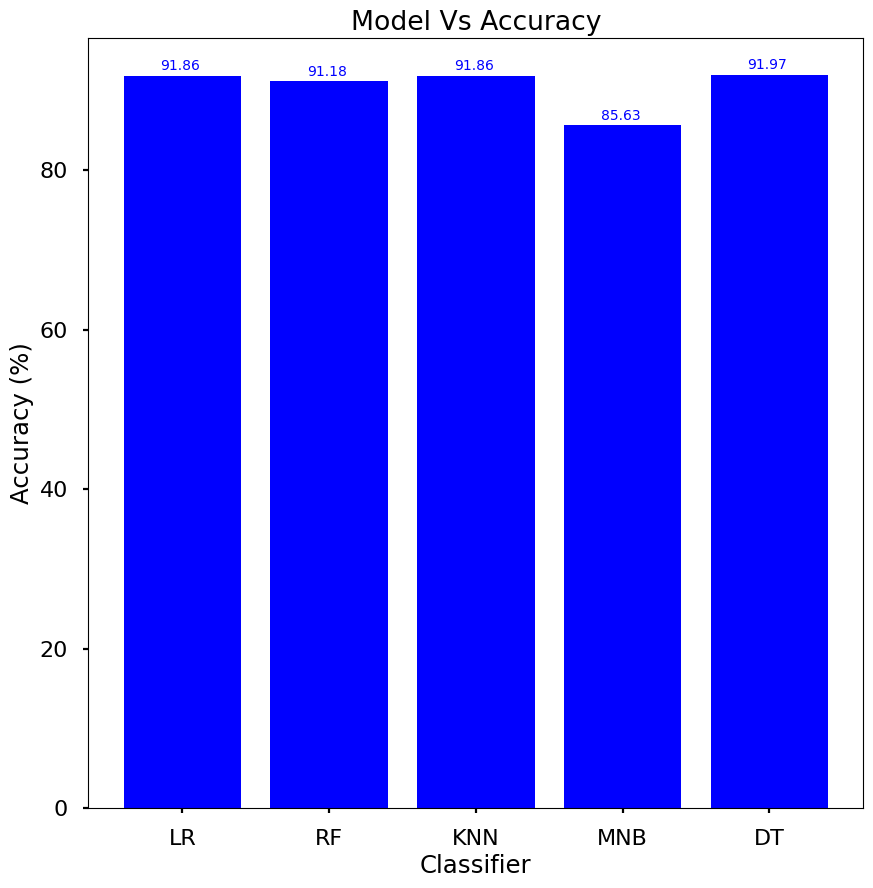

In [34]:
# comparison plot for all classifiers with their accuracy
plt.style.use('seaborn-poster')
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plt.title("Model Vs Accuracy")
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.bar(model_list, accuracy_list, color='blue')
for i, j in enumerate(accuracy_list):
    ax.text(float(i)-0.15, float(j)+0.7, str(j), color='blue')
plt.show()